In [ ]:
import numpy as np

%matplotlib inline

from matplotlib import pyplot as plt

from Timer import Timer

import IPythonMagic 

import pycuda
import pycuda.compiler as cuda_compiler
import pycuda.driver as cuda_driver
from pycuda.gpuarray import GPUArray

import pytest
from ipytest import clean_tests, run_pytest



In [ ]:
# From IPythonMagic file
%setup_logging
%cuda_context_handler

In [ ]:
class HeatEquation1D(object):
    """
    This class solver the 1D heat equation with an explicit finite differences method
    """
    #Constructor
    def __init__(self, u0, kappa, dx, dt):
        self.u0    = u0.copy() #Otherwise we have a pointer....
        self.u1    = np.empty_like(self.u0)
        self.kappa = kappa
        self.dx    = dx
        self.dt    = dt   
        self.nx    = self.u0.shape[0] - 2 # Excluding the boundary terms...
        
    def step(self):
        for i in range(1, self.nx+1):
            self.u1[i] = self.u0[i] \
                        + self.kappa*self.dt/(self.dx**2)*(self.u0[i-1] - 2.0*self.u0[i]+self.u0[i+1])
        self.u1[0] = self.u1[1]
        self.u1[self.nx+1] = self.u1[self.nx]
        self.u0, self.u1 = self.u1, self.u0
            
    def download(self):
        return self.u0.copy()

In [ ]:
class HeatEquation1D_GPU(object):
    """
    This class solver the 1D heat equation with an explicit finite differences method
    on the GPU
    """
    #Constructor
    def __init__(self):
        pass
    
    def createsKernel (self):
        src = """ 
        
        __global__ void heatEquation(float * u1, const float * u0, float kappa, float dx, float dt, int nx)
        {
                // To skip the first ghost cell (+1)
                int i = blockIdx.x * blockDim.x + threadIdx.x + 1;
                
                if (i >= 0 && i <= nx){
                    u1[i] = u0[i] + kappa*dt/(dx*dx)*(u0[i-1] - 2.0f*u0[i] + u0[i+1]);
                }
                
        }
        
        // This is a device function we can call from the kernel
        __device__ int computePi()
        {
            return 3.14156f;
        }
        
        """
        self.module = cuda_compiler.SourceModule(src, options = ['-use_fast_math'])
        
        self.kernel = self.module.get_function("heatEquation")
        self.kernel.prepare("PPfffi")
        
        # Create the kernel
        self.createKernel()
        
    def initialize(self, u0, kappa, dx, dt):
        self.kappa = np.float32(kappa)
        self.dx    = np.float32(dx)
        self.dt    = np.float32(dt)   
        self.nx    = np.int32(u0.shape[0] - 2) # Excluding the boundary terms...
        
        # Allocates and uploads
        assert u0.dtype == np.float32, "u0 must be float"
        self.u0_g = GPUArray(u0.shape, u0.dtype)
        self.u1_g = GPUArray(u0.shape, u0.dtype)
        self.u0_g.set(u0)
    
    def step(self):
        for i in range(1, self.nx+1):
            self.u1[i] = self.u0[i] \
                        + self.kappa*self.dt/(self.dx**2)*(self.u0[i-1] - 2.0*self.u0[i]+self.u0[i+1])
        self.u1[0] = self.u1[1]
        self.u1[self.nx+1] = self.u1[self.nx]
        self.u0, self.u1 = self.u1, self.u0
            
    def download(self):
        return self.u0.copy()

In [ ]:
    u0    = np.zeros(30)
    u0[15] = 1;
    kappa = 1.0
    dx    = 1.0
    dt    = 0.4 * dx**2 / (2*kappa) # To match the CFL condition for an explicit method. 

    simulator = HeatEquation1D(u0,kappa,dx,dt)
    
    simulator.step()
    
    
    print(u0)
    
    result = simulator.download()
    print(result)

In [ ]:
    u0    = np.zeros(5,dtype=np.float32)
    u0[2] = 1;
    kappa = 1.0
    dx    = 1.0
    dt    = 0.4 * dx**2 / (2*kappa) # To match the CFL condition for an explicit method. 

    gpu_simulator = HeatEquation1D_GPU()
    gpu_simulator.initialize(u0,kappa,dx,dt)
    
    #gpu_simulator.step()
    
    
    #print(u0)
    
    #result = simulator.download()
    #print(result)
    
    
    #for i in range(10):
    #simulator.step()
    #result = simulator.download()
    
#fig = plt.figure()
#plt.plot(result)


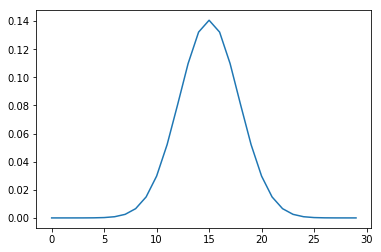

In [47]:
for i in range(10):
    simulator.step()
    result = simulator.download()
    
fig = plt.figure()
plt.plot(result)


In [18]:

clean_tests()

def test_Heat_Equation_1D():
    u0    = np.zeros(15)
    kappa = 1.0
    dx    = 1.0
    dt    = 0.4 * dx**2 / (2*kappa) # To match the CFL condition for an explicit method. 

    simulator = HeatEquation1D(u0,kappa,dx,dt)
    
    assert np.all(u0  == simulator.u0)
    assert kappa      == simulator.kappa
    assert dx         == simulator.dx
    assert dt         == simulator.dt
    #assert simulator.u0.shape() == simulator.u1.shape()
    
run_pytest(filename = "HeadEquation1D_Thomas.ipynb", pytest_options=['-vvv'])
    



============================= test session starts ==============================
platform linux -- Python 3.6.6, pytest-3.8.2, py-1.6.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /home/ubuntu/jupyter_notebooks/Thomas_Bellotti/MilanoGPU2018/notebooks, inifile:
collecting ... collected 1 item

HeadEquation1D_Thomas.py::test_Heat_Equation_1D <- <ipython-input-18-caf0a34e670d> FAILED [100%]

=================================== FAILURES ===================================
____________________________ test_Heat_Equation_1D _____________________________

    def test_Heat_Equation_1D():
        u0    = np.zeros(15)
        kappa = 1.0
        dx    = 1.0
        dt    = 0.4 * dx**2 / (2*kappa) # To match the CFL condition for an explicit method.
    
        simulator = HeatEquation1D(u0,kappa,dx,dt)
    
        assert np.all(u0  == simulator.u0)
        assert kappa      == simulator.kappa
        assert dx         == simulator.dx
        assert dt         == simulat

1